In [61]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
from scipy.signal import savgol_filter
import seaborn as sns
import ast
sns.set()

# Trajectories (obs, actions, penalty)

In [62]:
!ls ../data/a3c

a3c_trajectories_0.csv	a3c_trajectories_1.csv	a3c_trajectories_2.csv


In [81]:
path = path = "../results/2_new_NN_architecture/4_results_report/4_heterogeneous_goood/im_2/standby_2/gpu_10/"
#path = "../data/"
COLUMN_NAMES = ["util_0", "power_0", "it_0", "cool_0",
                "util_1", "power_1", "it_1", "cool_1",
                "util_2", "power_2", "it_2", "cool_2",
                "action", "penalty"]
df = pd.read_csv(path+'a3c/a3c_trajectories_0.csv',
                 delimiter=";",
                 names=COLUMN_NAMES,

                )
df

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,action,penalty
0,-2.949946,-5.148372,-5.148372,-5.148372,-2.949946,-4.875729,-5.148372,-4.875729,-2.949946,-4.875729,-5.148372,-4.875729,edc_2,False
1,-2.949946,-5.148372,-5.148372,-5.148372,-2.949946,-4.875729,-5.148372,-4.875729,-2.949946,-4.875729,-5.148372,-4.875729,edc_2,False
2,-2.949946,-3.884206,-4.185629,-4.846950,-2.949946,-4.143562,-4.370378,-4.921557,-2.949946,-4.143562,-4.370378,-4.921557,edc_2,False
3,-2.949946,-3.884206,-4.185629,-4.846950,-2.949946,-4.143562,-4.370378,-4.921557,-2.725288,-4.091402,-4.308651,-4.931123,edc_2,False
4,-2.949946,-3.884206,-4.185629,-4.846950,-2.949946,-4.143562,-4.370378,-4.921557,-2.500629,-4.025205,-4.232293,-4.941284,edc_2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,-2.949946,-3.884206,-4.185629,-4.846950,-1.938983,-2.765113,-2.906801,-5.006684,1.318566,0.072691,-0.089641,-4.986041,edc_2,False
2252,-2.949946,-3.884206,-4.185629,-4.846950,-1.938983,-2.765113,-2.906801,-5.006684,1.430895,0.110582,-0.053332,-4.984458,edc_2,False
2253,-2.949946,-3.884206,-4.185629,-4.846950,-1.826653,-2.748553,-2.889962,-5.006964,1.430895,0.110582,-0.053332,-4.984458,edc_2,False
2254,-2.949946,-3.884206,-4.185629,-4.846950,-1.826653,-2.748553,-2.889962,-5.006964,1.430895,0.110582,-0.053332,-4.984458,edc_2,False


In [82]:
df.action.value_counts()

edc_2    2185
edc_1      67
edc_0       4
Name: action, dtype: int64

In [83]:
df.penalty.value_counts()

False    1816
True      440
Name: penalty, dtype: int64

In [84]:
interval = 100
for i in range(len(df)//interval):
    print(df.iloc[i*interval:(i+1)*interval]["action"].value_counts())

edc_2    99
edc_0     1
Name: action, dtype: int64
edc_2    99
edc_1     1
Name: action, dtype: int64
edc_2    97
edc_1     3
Name: action, dtype: int64
edc_2    95
edc_1     5
Name: action, dtype: int64
edc_2    99
edc_1     1
Name: action, dtype: int64
edc_2    96
edc_1     3
edc_0     1
Name: action, dtype: int64
edc_2    94
edc_1     6
Name: action, dtype: int64
edc_2    99
edc_1     1
Name: action, dtype: int64
edc_2    98
edc_1     2
Name: action, dtype: int64
edc_2    98
edc_1     2
Name: action, dtype: int64
edc_2    92
edc_1     7
edc_0     1
Name: action, dtype: int64
edc_2    98
edc_1     2
Name: action, dtype: int64
edc_2    95
edc_1     5
Name: action, dtype: int64
edc_2    99
edc_1     1
Name: action, dtype: int64
edc_2    95
edc_1     5
Name: action, dtype: int64
edc_2    97
edc_1     2
edc_0     1
Name: action, dtype: int64
edc_2    97
edc_1     3
Name: action, dtype: int64
edc_2    99
edc_1     1
Name: action, dtype: int64
edc_2    100
Name: action, dtype: int64
edc_2 

In [85]:
gpus_per_edc = 10
scale_dict = {"normalization": {gpus_per_edc: {"power": (58*gpus_per_edc, 80*gpus_per_edc),
                                                        "util": (0, 100*gpus_per_edc),
                                                        "dist": (299.58, 2186.21)
                                                        },
                                        },
               "standarization": {5: {"power": (361.19, 25.89),
                                      "util": (268.08, 111.47),
                                      "dist": (1088.39, 540.25)
                                      },
                                  10: {"power": (944.16, 183.39),
                                       "util": (656.54, 222.56),
                                       "dist": (1088.39, 540.25)
                                       },
                                 }
                      }
scale_mode = "standarization"
scale_factor = gpus_per_edc


def inverse_scale_data(scale_data):
        if scale_mode == "normalization":
            return scale_data * (scale_pair[1] - scale_pair[0]) + scale_pair[0]
        if scale_mode == "standarization":
            return scale_data * scale_pair[1] + scale_pair[0]
        return scale_data
        
scaled_col = COLUMN_NAMES[:-2]

scaled_df = df.copy()
scale_pair = scale_dict[scale_mode][scale_factor]["util"]
scaled_df[scaled_col[0::4]] = scaled_df[scaled_col[0::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[1::4]] = scaled_df[scaled_col[1::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[2::4]] = scaled_df[scaled_col[2::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[3::4]] = scaled_df[scaled_col[3::4]].apply(inverse_scale_data)

for i in range(3):
    scaled_df["pue_"+str(i)] = scaled_df["power_"+str(i)] / scaled_df["it_"+str(i)]

scaled_df = scaled_df[~scaled_df.isin([np.nan, np.inf, -np.inf]).any(1)]

scaled_df.head(5)

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,action,penalty,pue_0,pue_1,pue_2
0,3.516609e-07,6.137338e-07,6.137338e-07,6.137338e-07,3.516609e-07,50.000001,6.137338e-07,50.000001,3.516609e-07,50.000001,6.137338e-07,50.000001,edc_2,False,1.000000,8.146854e+07,8.146854e+07
1,3.516609e-07,6.137338e-07,6.137338e-07,6.137338e-07,3.516609e-07,50.000001,6.137338e-07,50.000001,3.516609e-07,50.000001,6.137338e-07,50.000001,edc_2,False,1.000000,8.146854e+07,8.146854e+07
2,3.516609e-07,2.318354e+02,1.765575e+02,5.527787e+01,3.516609e-07,184.272196,1.426765e+02,41.595744,3.516609e-07,184.272196,1.426765e+02,41.595744,edc_2,False,1.313087,1.291539e+00,1.291539e+00
3,3.516609e-07,2.318354e+02,1.765575e+02,5.527787e+01,3.516609e-07,184.272196,1.426765e+02,41.595744,5.000000e+01,193.837871,1.539966e+02,39.841305,edc_2,False,1.313087,1.291539e+00,1.258716e+00
4,3.516609e-07,2.318354e+02,1.765575e+02,5.527787e+01,3.516609e-07,184.272196,1.426765e+02,41.595744,1.000000e+02,205.977717,1.679998e+02,37.977901,edc_2,False,1.313087,1.291539e+00,1.226059e+00


In [86]:
scaled_df.iloc[10:].describe()

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,pue_0,pue_1,pue_2
count,2.246000e+03,2246.000000,2246.000000,2246.000000,2.246000e+03,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2.246000e+03,2246.000000,2246.000000
mean,1.703028e+00,240.690476,183.301235,57.389241,1.819902e+02,383.249910,355.562222,27.687689,906.433660,950.151319,920.636482,29.514838,1.313087e+00,1.084675,1.032057
std,6.300243e+00,32.176684,24.504608,7.672075,5.463079e+01,60.014211,62.800183,3.046674,106.361223,23.239335,22.421552,0.824459,9.769943e-11,0.043603,0.000163
min,3.516609e-07,231.835379,176.557511,55.277869,3.516609e-07,184.272196,142.676453,25.826323,250.000000,775.201947,749.974121,25.227826,1.313087e+00,1.061370,1.031714
25%,3.516609e-07,231.835379,176.557511,55.277869,1.500000e+02,355.009047,327.081810,26.050877,875.000000,944.616271,915.368103,29.248169,1.313087e+00,1.063981,1.031976
50%,3.516609e-07,231.835379,176.557511,55.277869,2.000000e+02,370.299899,342.831665,27.468234,950.000000,957.993906,928.203133,29.790774,1.313087e+00,1.080122,1.032095
75%,3.516609e-07,231.835379,176.557511,55.277869,2.250000e+02,433.219143,407.168267,27.927237,975.000000,964.439682,934.379478,30.060205,1.313087e+00,1.085383,1.032171
max,2.500000e+01,359.552989,273.822663,85.730327,2.750000e+02,446.654898,420.828575,41.595744,1000.000000,967.664681,937.467651,30.197030,1.313087e+00,1.291539,1.033638


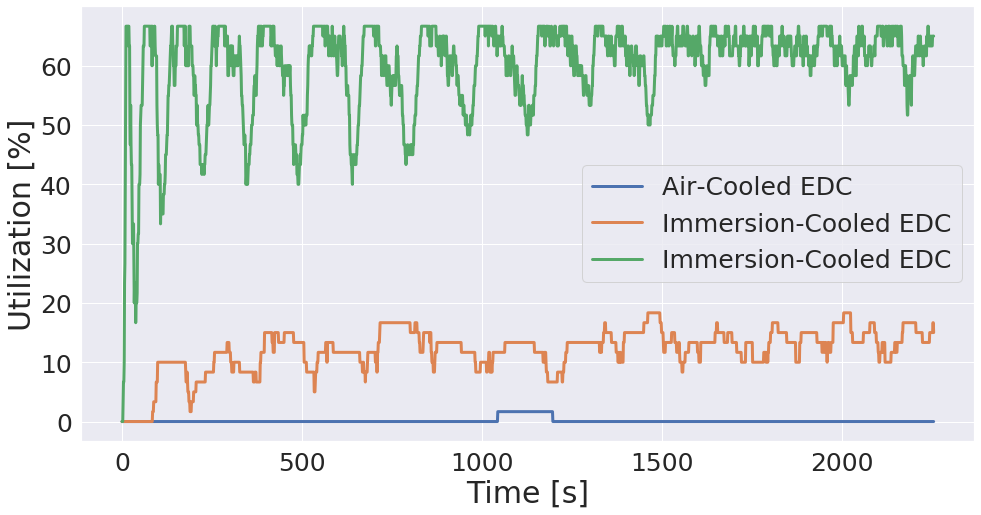

In [87]:
plt.figure(figsize=(16,8))
plt.plot(scaled_df["util_0"][:]/15, label="Air-Cooled EDC", linewidth=3)
plt.plot(scaled_df["util_1"][:]/15, label="Immersion-Cooled EDC", linewidth=3)
plt.plot(scaled_df["util_2"][:]/15, label="Immersion-Cooled EDC", linewidth=3)

plt.ylabel("Utilization [%]", fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.show()

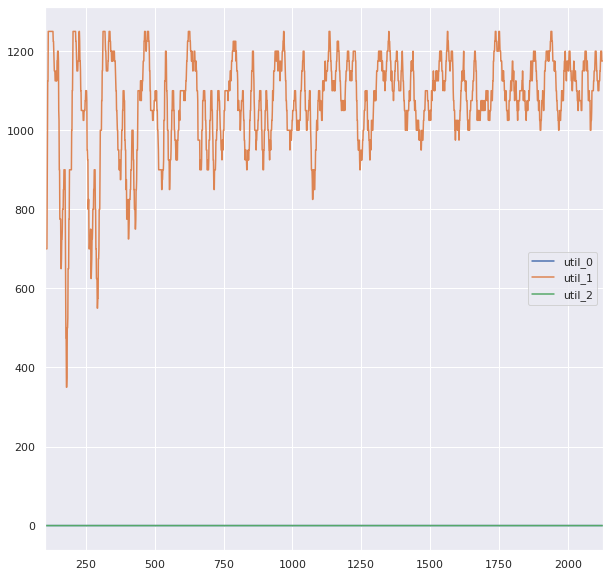

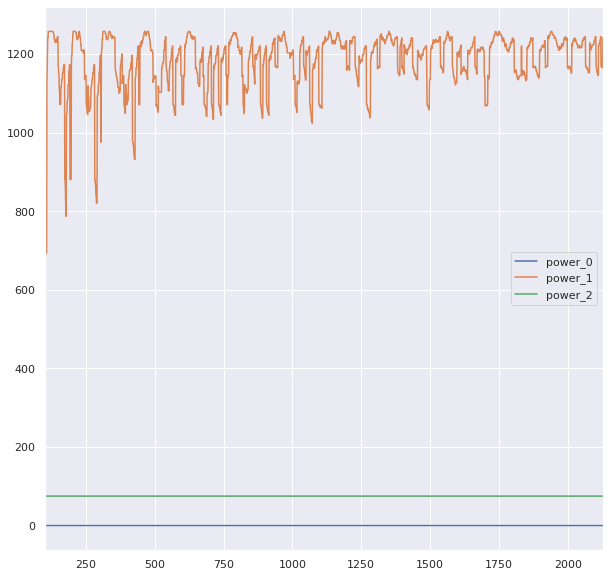

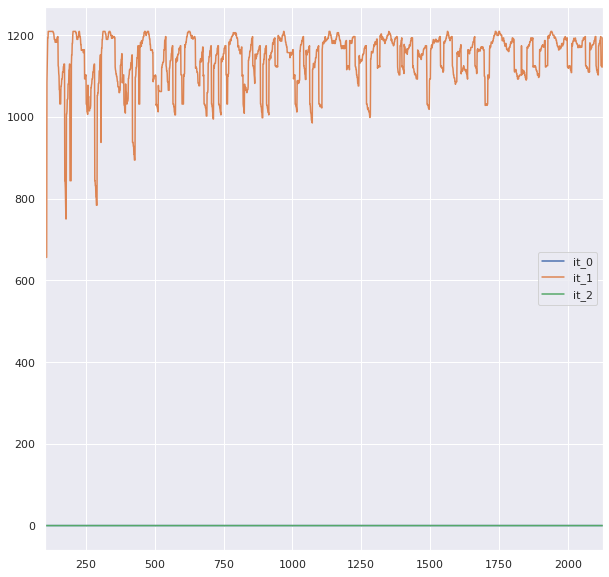

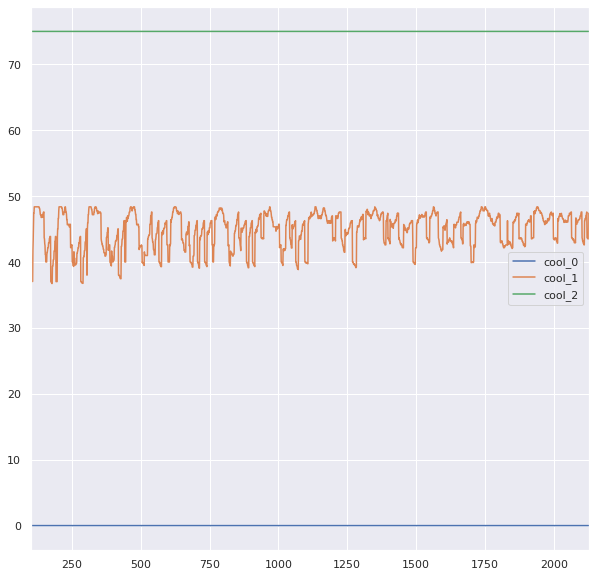

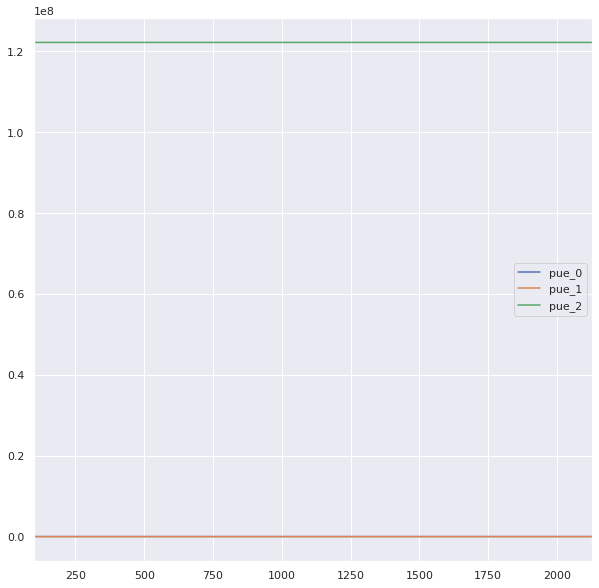

In [76]:
for col in ["util", "power", "it", "cool","pue"]:
    scaled_df.iloc[100:].plot(y=[col+"_0", col+"_1", col+"_2"], figsize=(10,10))

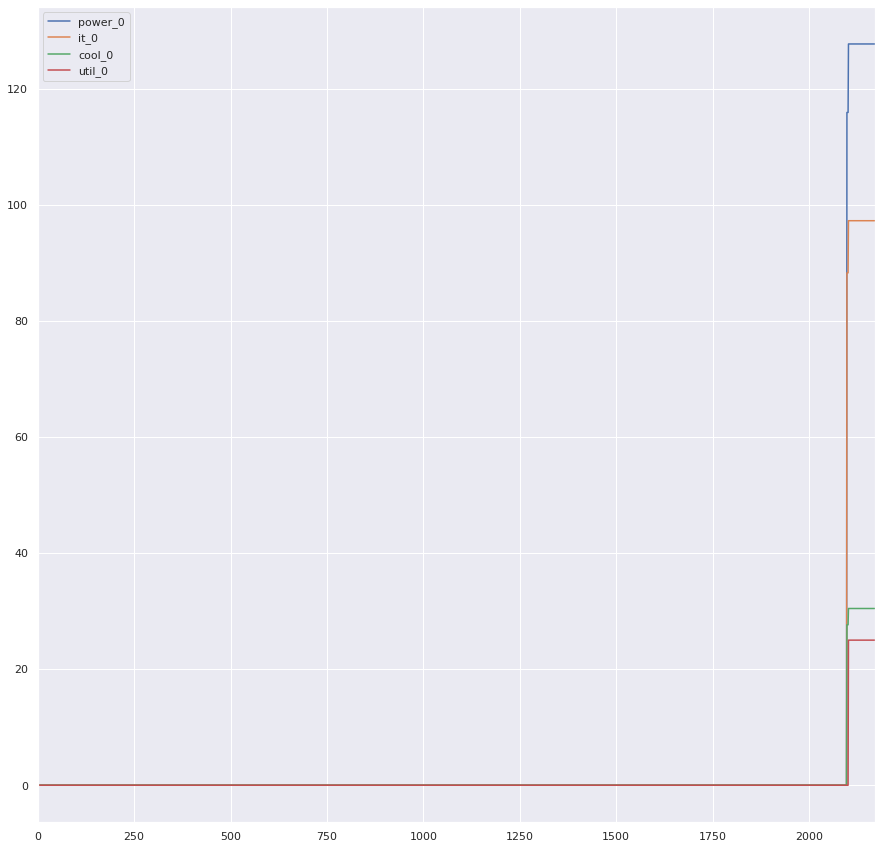

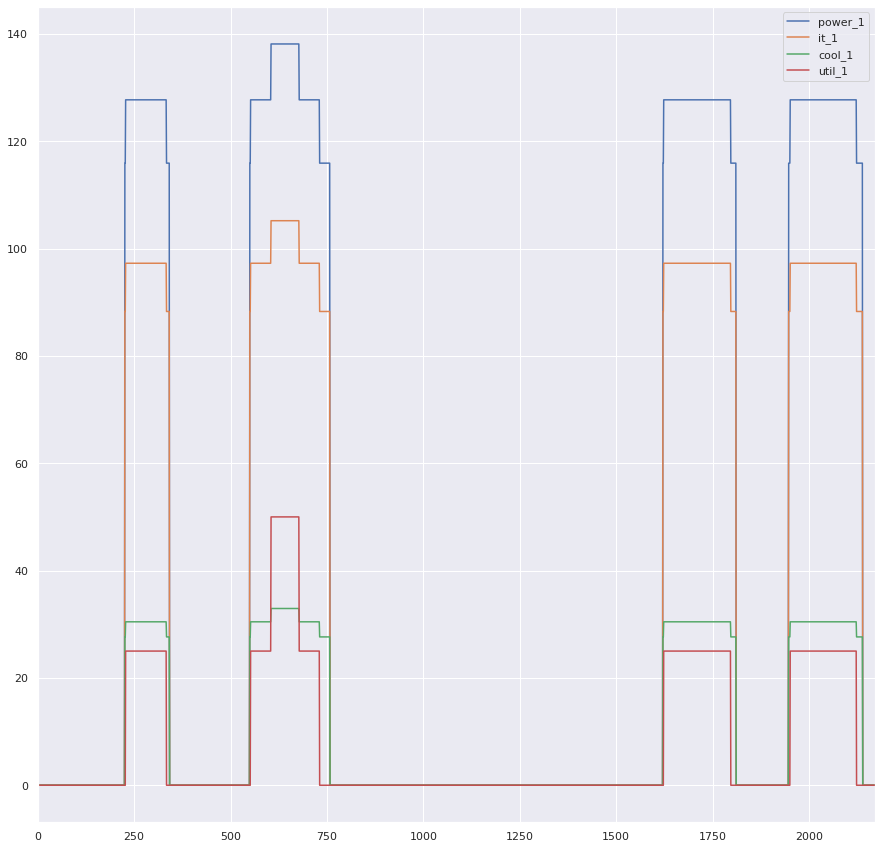

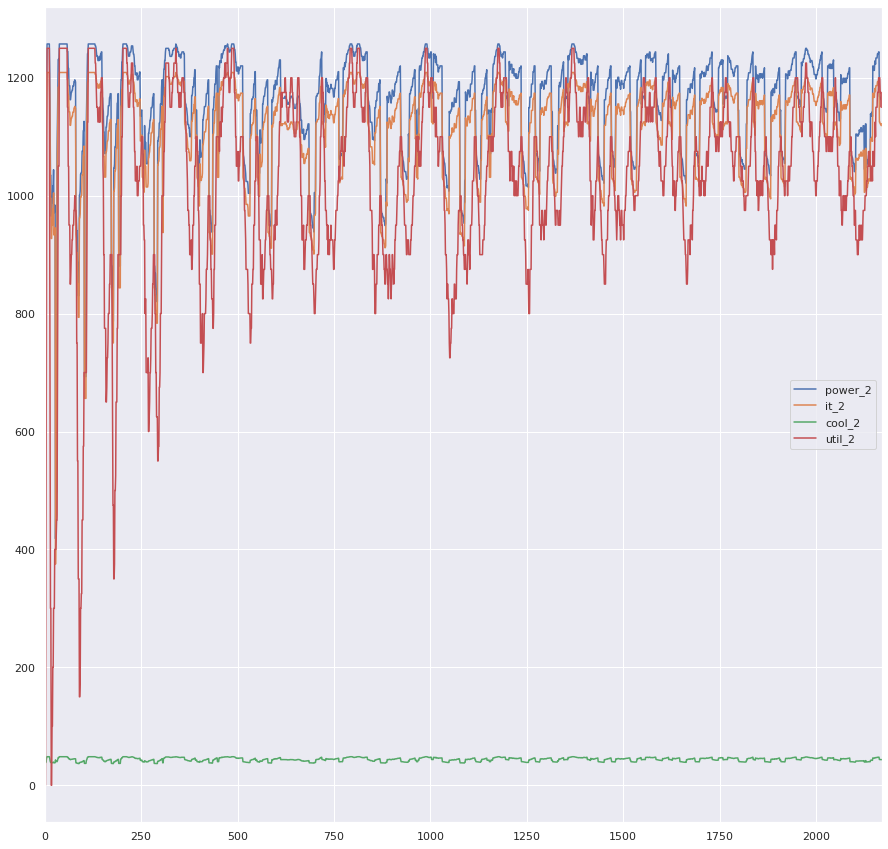

In [12]:
for i in range(3):
    scaled_df.plot(y=["power_"+str(i),"it_"+str(i),"cool_"+str(i),"util_"+str(i)], figsize=(15,15))

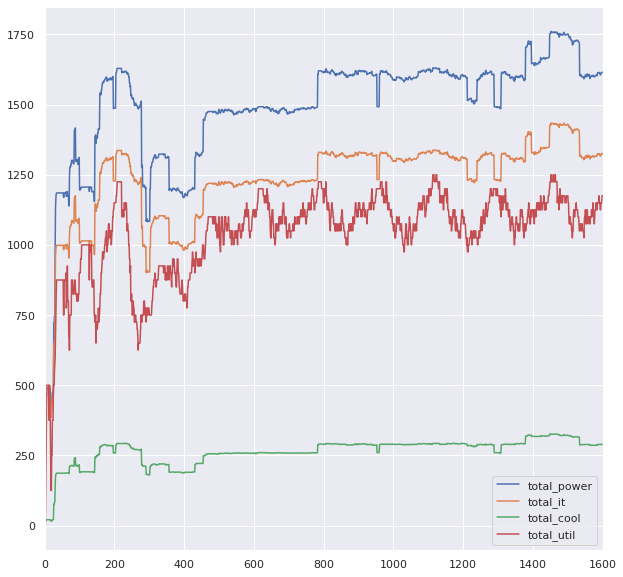

In [319]:
scaled_df["total_power"] = scaled_df["power_0"] + scaled_df["power_1"] + scaled_df["power_2"]
scaled_df["total_it"] = scaled_df["it_0"] + scaled_df["it_1"] + scaled_df["it_2"]
scaled_df["total_cool"] = scaled_df["cool_0"] + scaled_df["cool_1"] + scaled_df["cool_2"]
scaled_df["total_util"] = scaled_df["util_0"] + scaled_df["util_1"] + scaled_df["util_2"]
scaled_df.plot(y=[col for col in scaled_df.columns if "total" in col], figsize=(10,10))
plt.show()

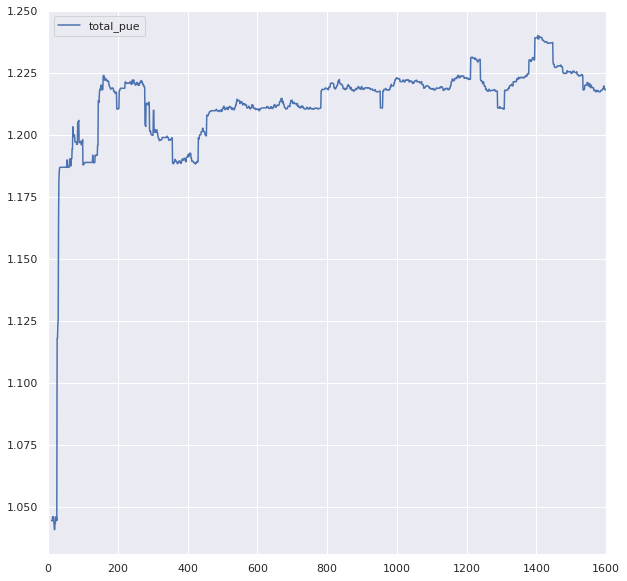

In [320]:
scaled_df["total_pue"] = scaled_df["total_power"].iloc[10:]  / scaled_df["total_it"].iloc[10:]
scaled_df.plot(y="total_pue", figsize=(10,10))
plt.show()

In [321]:
scaled_df.iloc[10:].describe()

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,pue_0,pue_1,pue_2,total_power,total_it,total_cool,total_util,total_pue
count,1.591000e+03,1.591000e+03,1.591000e+03,1.591000e+03,1.591000e+03,1.591000e+03,1.591000e+03,1.591000e+03,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000,1591.000000
mean,1.707574e+02,3.435275e+02,2.616182e+02,8.190927e+01,4.342238e+02,6.835819e+02,5.205914e+02,1.629904e+02,439.503457,473.234631,453.016303,20.218329,1.299115,1.309151,1.044575,1500.343972,1235.225944,265.118030,1044.484601,1.212457
std,8.359592e+01,1.326165e+02,1.009960e+02,3.162053e+01,7.824336e+01,9.702954e+01,7.389422e+01,2.313532e+01,67.437172,27.179053,25.671380,1.565040,0.064667,0.034893,0.001424,189.711803,144.493792,45.577575,145.824434,0.021048
min,3.516609e-07,6.137338e-07,6.137338e-07,6.137338e-07,3.516609e-07,6.137338e-07,6.137338e-07,6.137338e-07,125.000000,366.378872,352.405175,13.973698,1.000000,1.000000,1.039652,400.671608,384.991419,15.680192,125.000001,1.040729
25%,1.250000e+02,2.814051e+02,2.143081e+02,6.709708e+01,4.000000e+02,7.059430e+02,5.376208e+02,1.683221e+02,400.000000,470.029586,449.240113,20.789474,1.313087,1.313087,1.044352,1473.199201,1215.808587,257.471866,1000.000001,1.210552
50%,1.750000e+02,4.073568e+02,3.102283e+02,9.712847e+01,4.500000e+02,7.128609e+02,5.428893e+02,1.699716e+02,475.000000,486.435127,465.645653,20.789474,1.313087,1.313087,1.044647,1588.574966,1299.803407,286.339211,1075.000000,1.218117
75%,2.250000e+02,4.229178e+02,3.220790e+02,1.008388e+02,4.750000e+02,7.146268e+02,5.442342e+02,1.703927e+02,500.000000,489.523300,468.733826,20.789474,1.313087,1.313087,1.045294,1613.272869,1323.196321,290.381147,1125.000000,1.221206
max,3.500000e+02,5.679622e+02,4.325397e+02,1.354226e+02,5.000000e+02,7.163928e+02,5.455790e+02,1.708137e+02,500.000000,489.523300,468.733826,20.789474,1.313087,1.313087,1.046617,1760.599561,1434.415925,326.604702,1250.000000,1.240156



# REWARD, Q-VALUES, ETC. INFO

In [322]:
!ls ../info/

dist.txt  mercury_info_parsed  train_arrays.txt  vanilla_a3c_training_info.txt


In [361]:
df_2 = pd.read_csv('../info/train_arrays.txt',
                   delimiter=",",
                   names=["log_prob", "_", "reward", "v_vals",
                          "q_vals", "entropy"])
df_2 = df_2.drop(["_"], axis=1)
df_2["log_prob"] = df_2["log_prob"].apply(lambda x: x.split("(")[1])
df_2["log_prob"] = df_2["log_prob"].astype("float64")



df_2["a_vals"] = df_2.q_vals - df_2.v_vals

df_2

,log_prob,reward,v_vals,q_vals,entropy,a_vals
0,-0.9327,-1932.469238,0.371843,3.087844,1.087659,2.716001
1,-0.9327,-1932.469238,0.371843,3.150659,1.087659,2.778816
2,-1.0980,-1932.469238,0.371843,3.214109,1.087659,2.842266
3,-0.9327,-1932.469238,0.371843,3.278200,1.087659,2.906357
4,-1.0980,-1932.469238,0.371843,3.342938,1.087659,2.971095
...,...,...,...,...,...,...
141328,-1.7792,-1591.967896,0.361607,0.096681,0.939614,-0.264926
141329,-1.7792,-1591.967896,0.361607,0.097588,0.939614,-0.264019
141330,-0.4975,-1591.967896,0.363944,0.098505,0.936195,-0.265439
141331,-1.4802,-1581.558960,0.363944,0.099431,0.936195,-0.264513


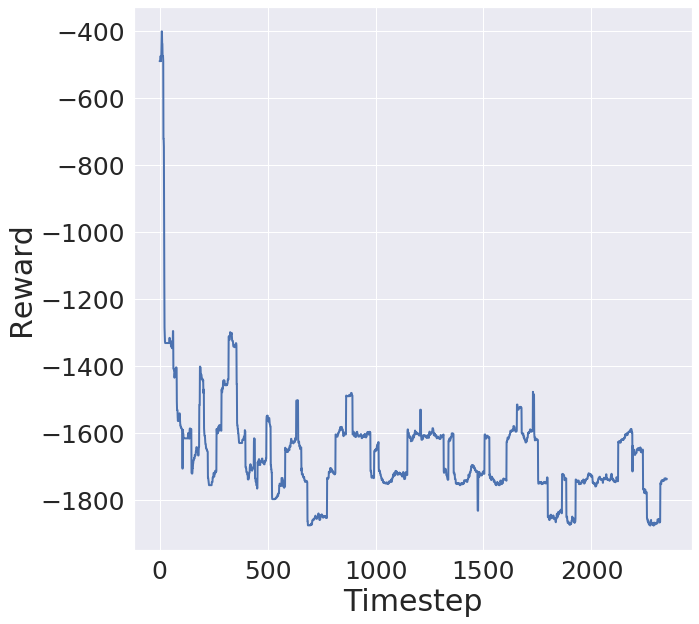

In [324]:

GAMMA = 0.0
rew = df_2.reward.iloc[:2350].values
#rew = (rew - np.mean(rew)) / (np.std(rew) + 0.00000000000000000001)
q_val = rew[-1]
q_vals = np.zeros_like(rew)

for i in reversed(range(len(rew))):
    q_val_temp = q_val
    q_val = rew[i] + GAMMA * q_val
    q_vals[i] = q_val
#q_vals = (q_vals - np.mean(q_vals)) / (np.std(q_vals) + 0.00000000000000000001)

plt.figure(figsize=(10,10))
plt.plot(q_vals, linewidth=2)
plt.ylabel("Reward", fontsize=30)
plt.xlabel('Timestep', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.legend(fontsize=25)
plt.show()


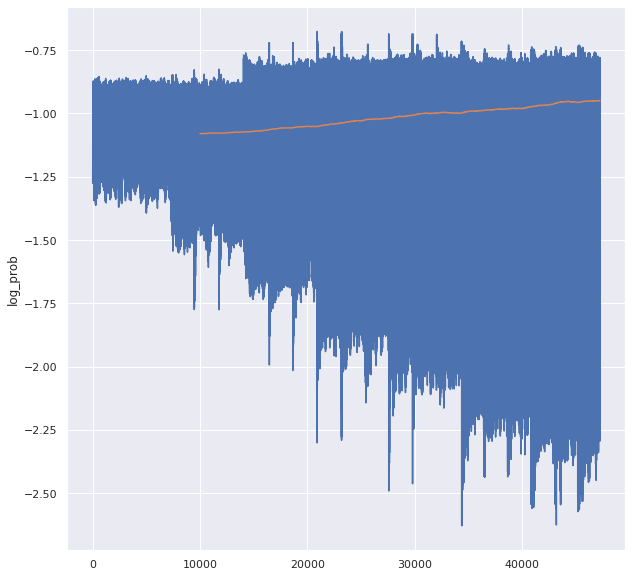

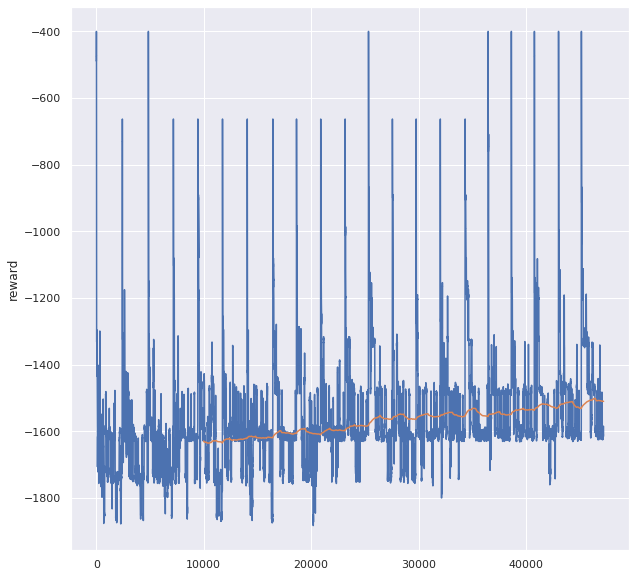

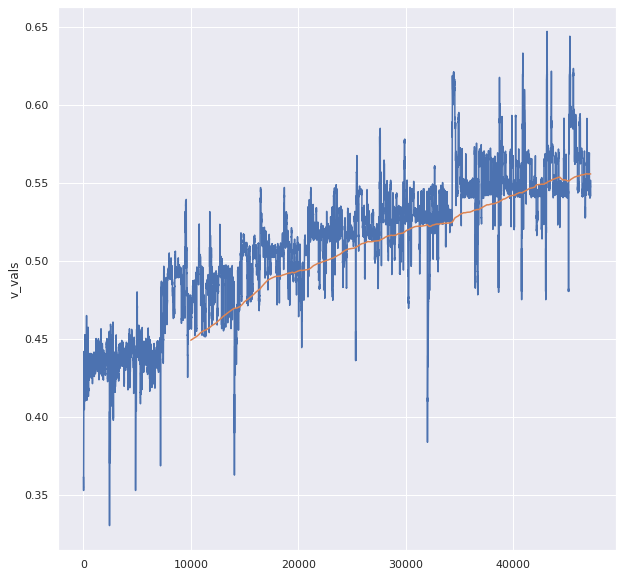

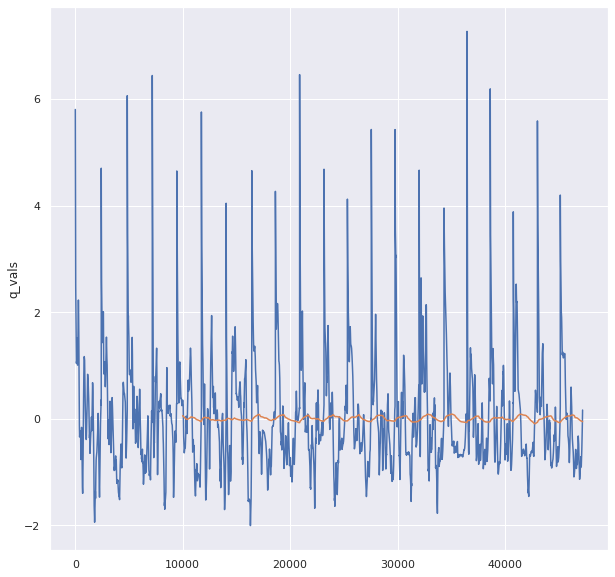

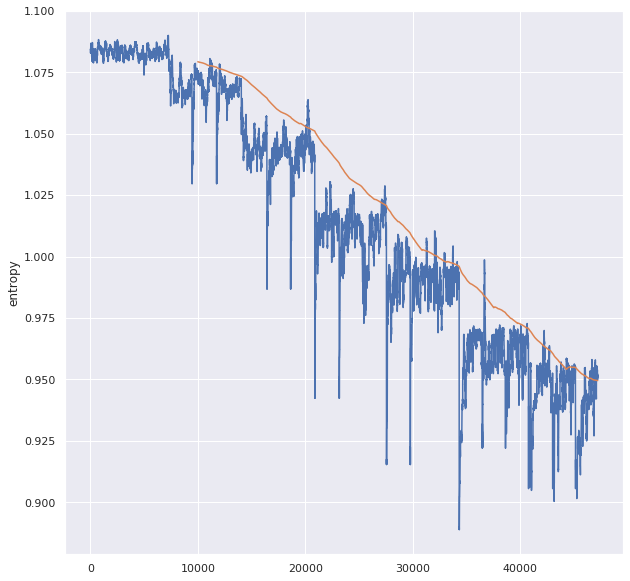

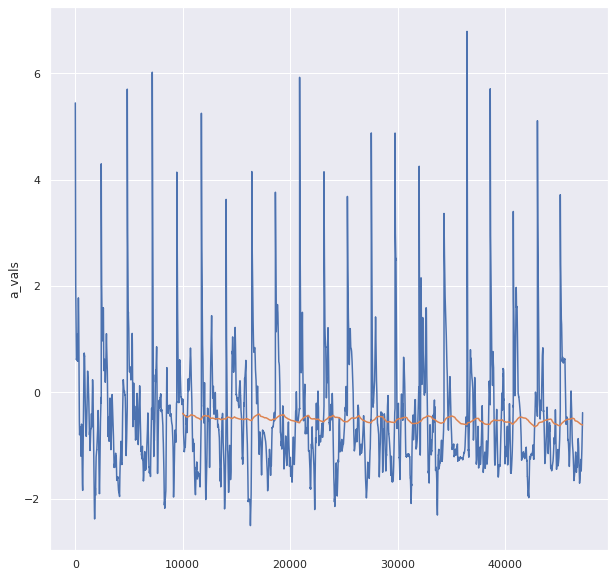

In [325]:
for col in df_2.columns:
    plt.figure(figsize=(10,10))
    plt.plot(df_2[col])
    plt.plot(pd.Series.rolling(pd.Series(df_2[col]), 10000).mean())
    plt.ylabel(col)
    plt.show()

# DISTRIBUTION INFO

In [364]:
df_3 = pd.read_csv('../info/dist.txt', delimiter=",", names=["dist"])
df_3["edc_0"] = df_3.dist.apply(lambda x: list(filter(lambda a: a is not "", x.split(" ")))[0][1:])
df_3["edc_1"] = df_3.dist.apply(lambda x: list(filter(lambda a: a is not "", x.split(" ")))[1])
df_3["edc_2"] = df_3.dist.apply(lambda x: list(filter(lambda a: a is not "", x.split(" ")))[2][:-1])

df_3.edc_0 = df_3.edc_0.astype("float64")
df_3.edc_1 = df_3.edc_1.astype("float64")
df_3.edc_2 = df_3.edc_2.astype("float64")

df_3 = df_3.drop(["dist"], axis=1)

df_3

,edc_0,edc_1,edc_2
0,0.272988,0.393485,0.333527
1,0.272988,0.393485,0.333527
2,0.272988,0.393485,0.333527
3,0.272988,0.393485,0.333527
4,0.272988,0.393485,0.333527
...,...,...,...
279032,0.010832,0.021219,0.967949
279033,0.010832,0.021219,0.967949
279034,0.010669,0.020756,0.968575
279035,0.010669,0.020756,0.968575


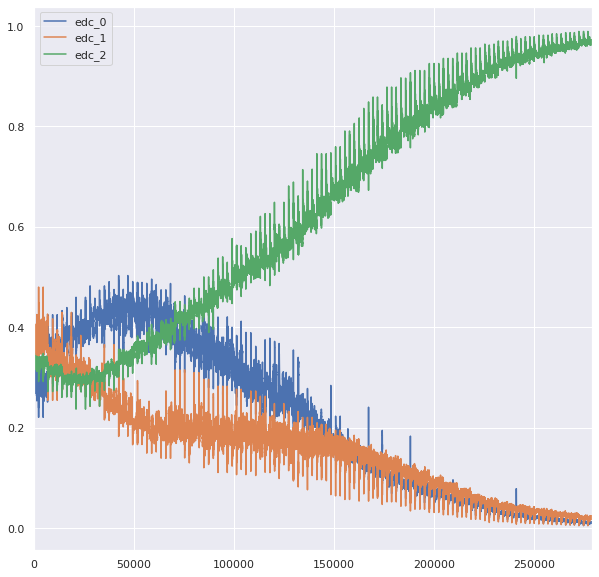

In [365]:
df_3.iloc[:].plot(y=["edc_0","edc_1","edc_2"], figsize=(10,10))

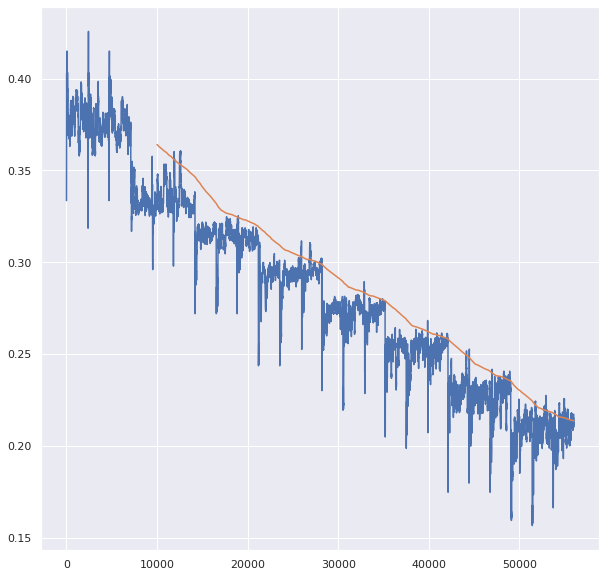

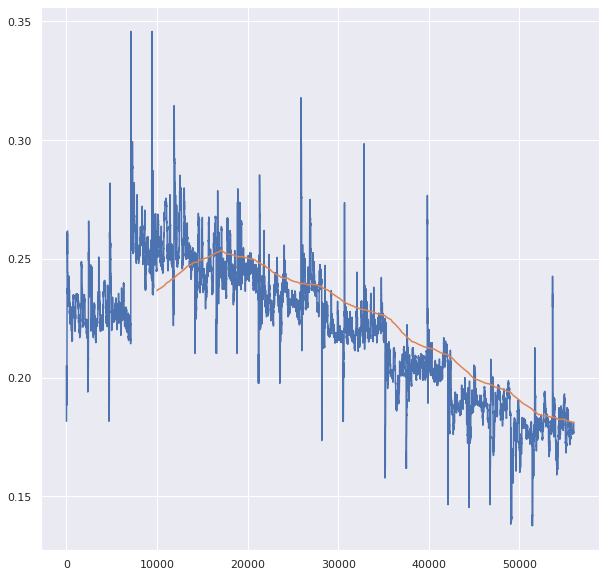

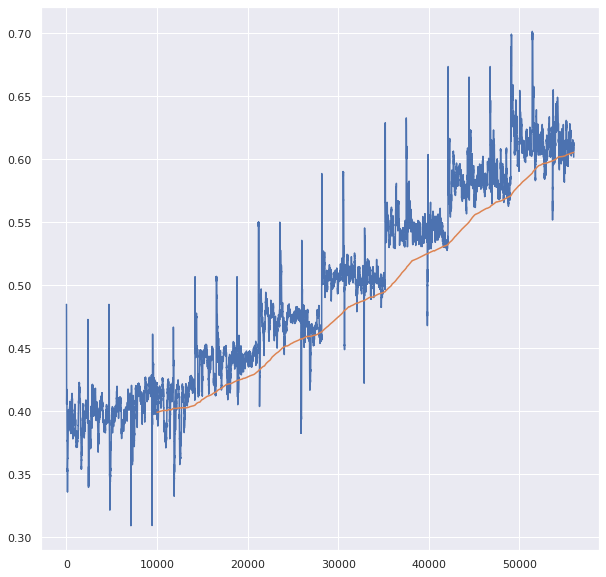

In [337]:
for col in df_3.columns:
    plt.figure(figsize=(10,10))
    plt.plot(df_3[col])
    plt.plot(pd.Series.rolling(pd.Series(df_3[col]), 10000).mean())
plt.show()


# REWARD COMPUTATION

In [103]:
"""  
### OPTION 1 ### no scale

if penalty[i]:
    reward = -AVAILABILITY_PENALTY
else:
    power_consumption = x[i+1, 1::2]
    reward = -np.sum(np.power(power_consumption, 3))

### OPTION 2 ### scale  

if penalty[i]:
    reward = -AVAILABILITY_PENALTY
else:
    utilization = x[i+1, 0::2]
    power_consumption = x[i+1, 1::2]
    reward = -np.sum(np.power(power_consumption/(utilization+1), 1))
if reward<-AVAILABILITY_PENALTY:
    reward = -AVAILABILITY_PENALTY

### OPTION 3 ### no scale, penalty = 0.5
wrong for positive numbers, although it always gives negative number with standard
not intended scaling for (-1,1) range using pow 3 -> not relevant for rewards around 50-100 but still "wrong"

power_consumption = x[i+1, 1::2]
total_power = np.sum(np.power(power_consumption, 3))
pen = penalty[i]
reward = - (1 - AVAILABILITY_PENALTY * pen) * total_power

### OPTION 4 ### scale, penalty= 1,10,20

offset = np.sum(np.mean(x[:, 1::2], axis=0))/x[:, 1::2].shape[1]

power_consumption = x[i+1, 1::2] - offset
total_power = np.power(np.sum(power_consumption), 1)
pen = penalty[i]
if total_power > 0:
    reward = - (1 + AVAILABILITY_PENALTY * pen) * total_power
else:
    reward = - (1 - AVAILABILITY_PENALTY * pen) * total_power
"""
print()

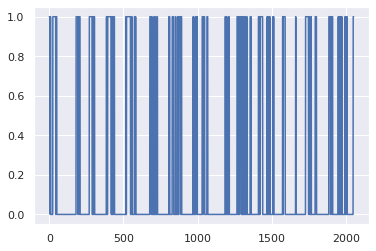

(2053, 12)


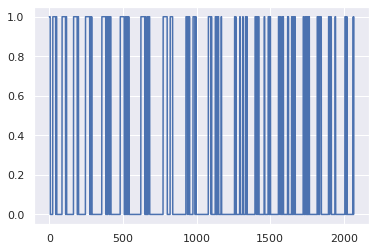

(2067, 12)


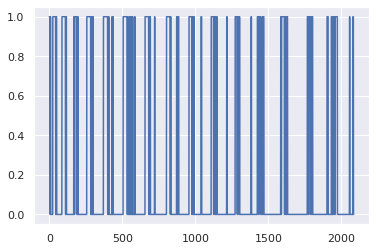

(2085, 12)
3 2066


In [354]:
EPSILON = np.finfo(np.float32).eps
AVAILABILITY_PENALTY = 0

rewards = []
#directory = "../results/vanilla_a3c_v2_lite_env_6_UE_50_GPUperEDC_10_standarize_data&Qvalues_reward_sumrealPOP1P2adam_1e3_ep_30_penalty_1_neurons_128/a3c/"
#directory = "../data/a3c/"
directory = path + "/a3c/"


for filename in sorted(os.listdir(directory)):
    
    tmp_cols = COLUMN_NAMES
    
    df_tmp = pd.read_csv(os.path.join(directory, filename), delimiter=";", names=tmp_cols).iloc[6:]
    
    
    x = df_tmp[COLUMN_NAMES[:-2]].values
    penalty = df_tmp["penalty"].values
    
    
    scale_pair = scale_dict[scale_mode][scale_factor]["util"]
    x[:,0::4] = inverse_scale_data(x[:, 0::4])

    scale_pair = scale_dict[scale_mode][scale_factor]["power"]
    x[:,1::4] = inverse_scale_data(x[:, 1::4])
    
    """
    offset = inverse_scale_data(offset)
    offset = np.sum(np.mean(x[:, 1::5], axis=0))/x[:, 1::5].shape[1]
    print(offset)
    """

    plt.plot(penalty)
    plt.show()
    
    
    ep_rewards = []
    print(x.shape)
    
    for i in range(len(x)-1):
        
        power_consumption = x[i+1, 1::4] # total power
        total_power = np.power(np.sum(power_consumption), 1)
        pen = penalty[i]
        if total_power > 0:
            reward = - (1 + AVAILABILITY_PENALTY * pen) * total_power
        else:
            reward = - (1 - AVAILABILITY_PENALTY * pen) * total_power
        
        ep_rewards.append(reward)
    rewards.append(ep_rewards)

print(len(rewards), len(rewards[1]))

In [355]:
df_tmp.columns[:-2]

Index(['util_0', 'power_0', 'it_0', 'cool_0', 'util_1', 'power_1', 'it_1',
       'cool_1', 'util_2', 'power_2', 'it_2', 'cool_2'],
      dtype='object')

mean reward 0: -1310.5316328777844
mean reward 1: -1332.467400836283
mean reward 2: -1312.156626779958


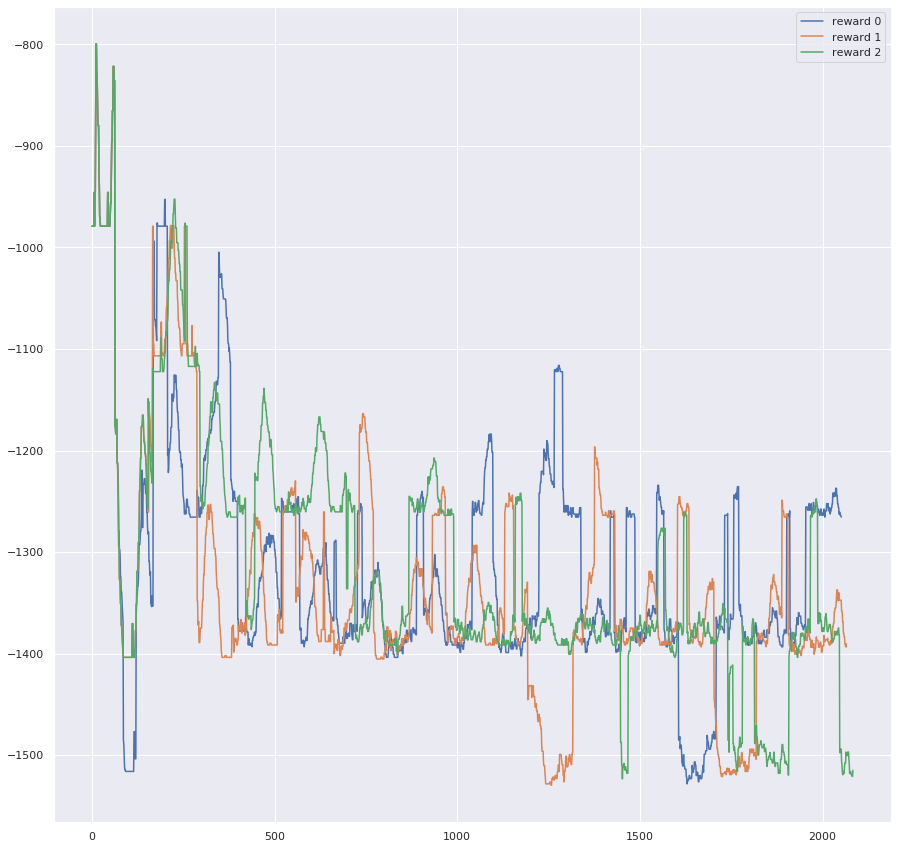

In [356]:
plt.figure(figsize=(15,15))
for i in range(len(rewards)):
    print("mean reward {}: {}".format(i, sum(rewards[i])/len(rewards[i])))
    plt.plot(rewards[i][:])
plt.legend(["reward "+str(i) for i in range(len(rewards))])
plt.show()

# Episodes: Loss, Mean Reward, etc.

In [34]:
! ls ../info

dist.txt	     vanilla_a3c_training_info.txt
mercury_info_parsed  vanilla_a3c_training_results.csv
train_arrays.txt


In [35]:
df_4 = pd.read_csv('../info/vanilla_a3c_training_results.csv',
                   delimiter=";",
                   names=["episodes", "length", "rewards", "loss", "entropies"])
df_4

,episodes,length,rewards,loss,entropies
0,0,7075,-1.267498e+07,1.042144,-0.001080
1,1,7126,-1.281042e+07,0.935626,-0.001037
2,2,7112,-1.263619e+07,0.906153,-0.000991
3,3,7111,-1.274150e+07,0.839935,-0.000949
4,4,7256,-1.289580e+07,0.845807,-0.000883
5,0,7112,-1.254237e+07,0.777698,-0.000400
6,1,7065,-1.239840e+07,0.786026,-0.000329
7,2,7117,-1.240619e+07,0.801565,-0.000258
8,3,7073,-1.236008e+07,0.813075,-0.000215
9,4,7121,-1.241755e+07,0.770633,-0.000188


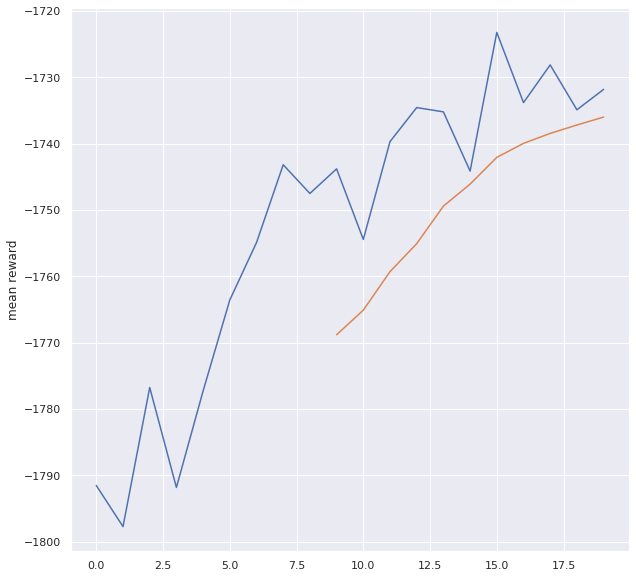

In [36]:
plt.figure(figsize=(10,10))
plt.plot(df_4["rewards"]/df_4["length"])
plt.plot(pd.Series.rolling(pd.Series(df_4["rewards"]/df_4["length"]), 10).mean())
plt.ylabel("mean reward")
plt.show()

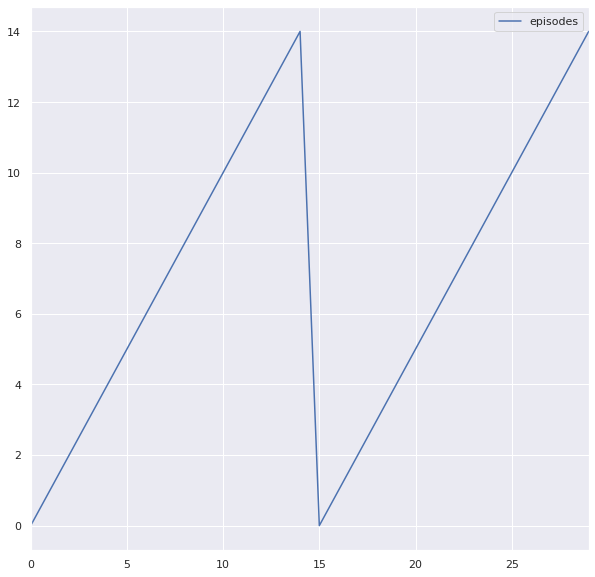

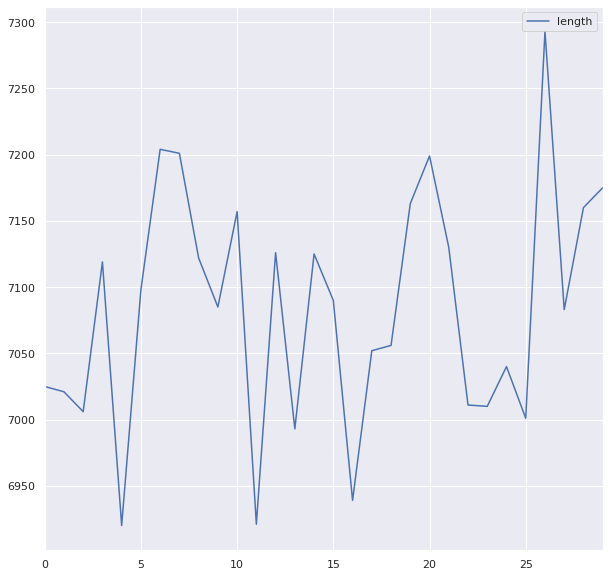

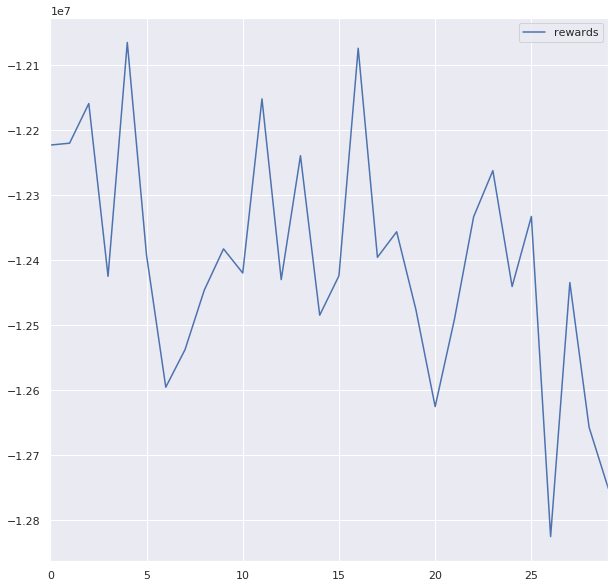

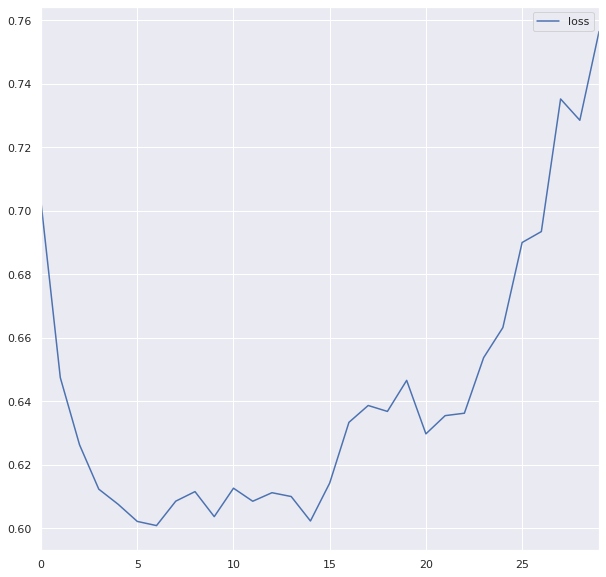

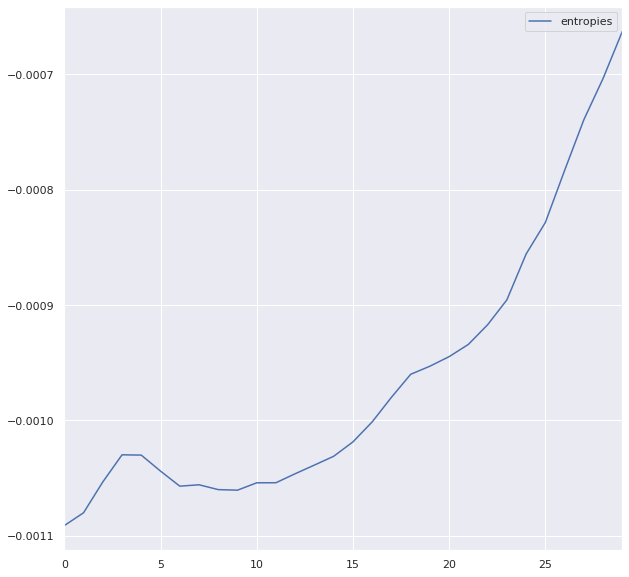

In [221]:
for col in df_4.columns:
    df_4.plot(y=col, figsize=(10,10))

# Episodes (2nd Option)

### Training info file must be cleaned before!! (remove lines with no commas)

In [96]:
df_5 = pd.read_csv('../info/vanilla_a3c_training_info.txt',
                   delimiter=",",
                   names=["episodes", "time", "length", "mean rewards", "loss"])

def compute_loss(x):
    losses = x.split(":")[1].split(" ")
    return sum([float(l) for l in losses[1:]])

for col in df_5.columns[:-1]:
    df_5[col] = df_5[col].str.split(":").str[1].astype(np.float)
df_5["entropy"] =  df_5["loss"].str.split(":").str[1].str.split(" ").str[3].astype(np.float)
df_5["loss"] =  df_5["loss"].apply(compute_loss)
df_5

AttributeError: 'float' object has no attribute 'split'

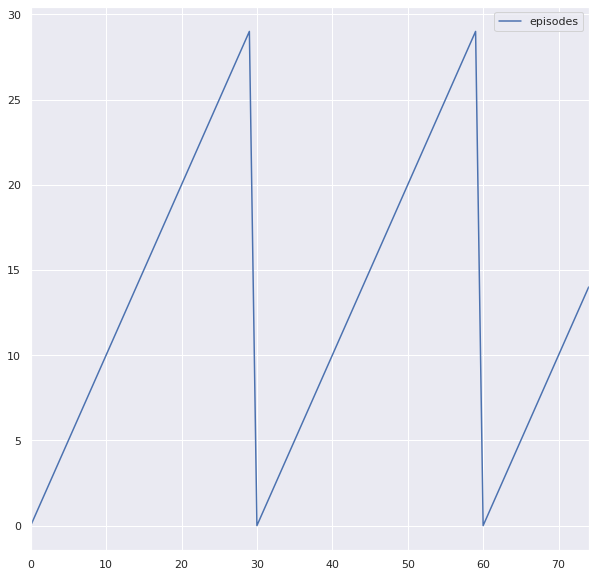

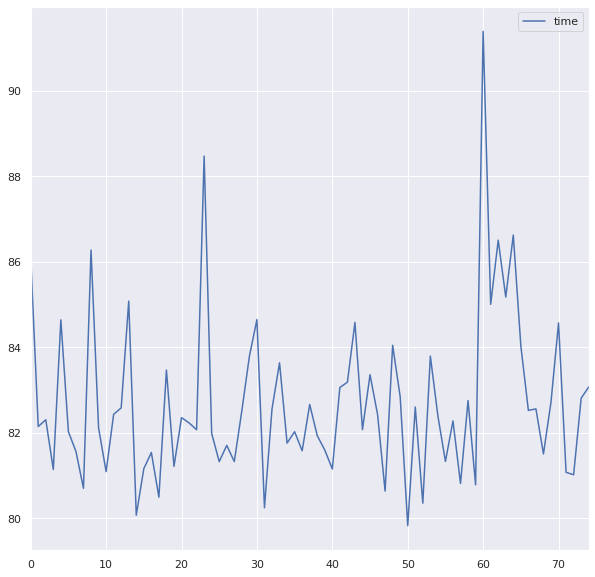

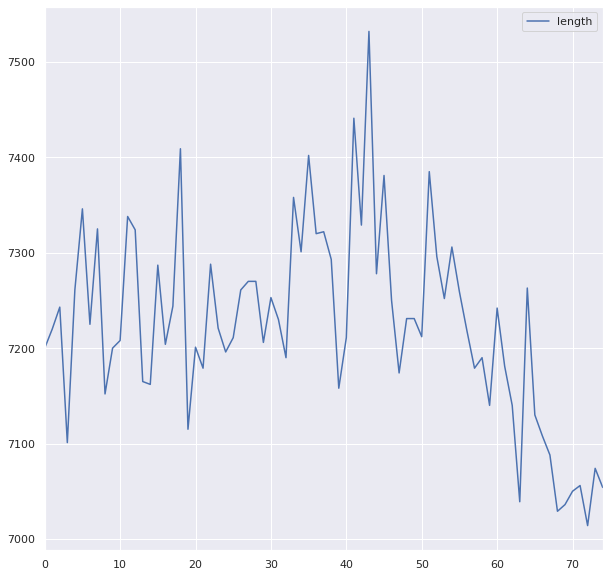

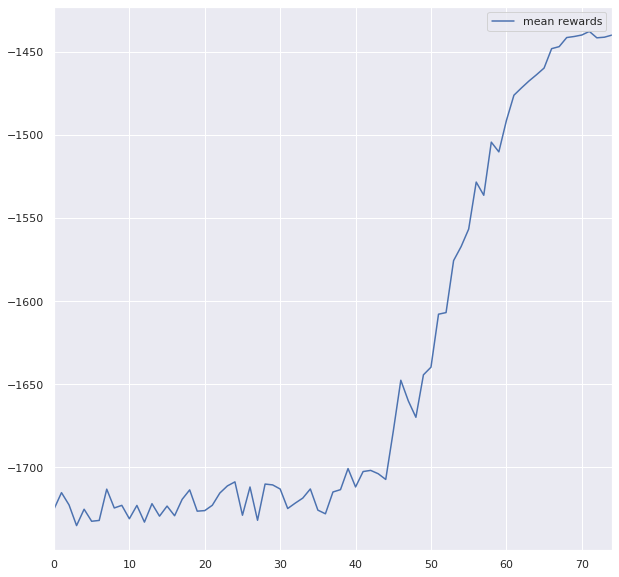

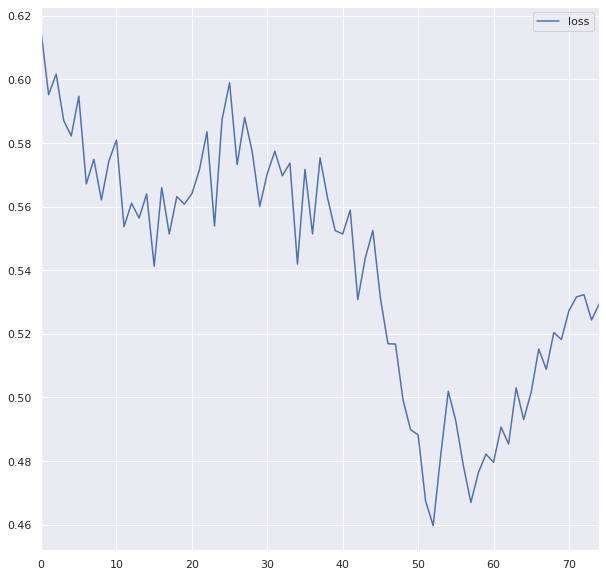

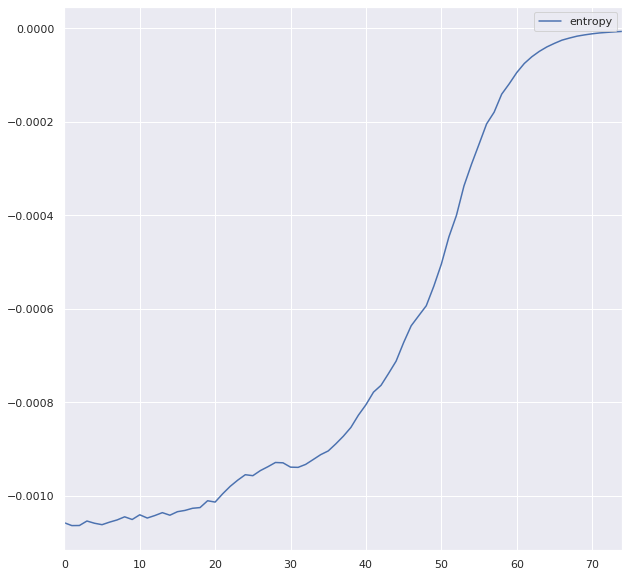

In [77]:
for col in df_5.columns:
    df_5.plot(y=col, figsize=(10,10))

# Extra

In [347]:
xxxx

array([-1000.,  -999.,  -998., ...,   998.,   999.,  1000.])

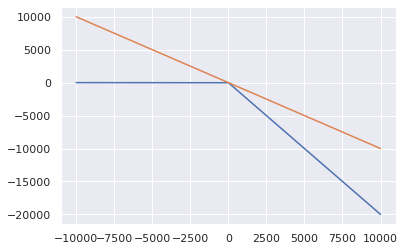

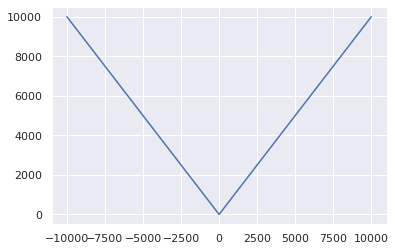

In [550]:
xxxx = np.linspace(-10000,10000, num=20001)
yyyy = []
AVAILABILITY_PENALTY = 1
for xxx in xxxx:
    if xxx > 0:
        yyy = - (1 + AVAILABILITY_PENALTY) * xxx
    else:
        yyy = - (1 - AVAILABILITY_PENALTY) * xxx
            
    yyyy.append(yyy)

plt.plot(xxxx, yyyy)
plt.plot(xxxx, -xxxx)
plt.show()
plt.plot(xxxx, -xxxx-yyyy)
plt.show()
